# Section 5.1: proportion of all bot edits to articles that are bot-bot reverts

This is a data analysis script for an analysis presented in section 5.1, which you can run based entirely off the files in this GitHub repository. It loads `datasets/montly_bot_edits/[language]wiki_20170427.tsv` and `datasets_monthly_bot_reverts/[language]wiki_20170420.tsv`.

In [1]:
import pandas as pd
import seaborn as sns
import mwapi
import numpy as np
import glob
%matplotlib inline

In [2]:
!ls ../../datasets/monthly_bot_edits/

dewiki_20170427.tsv  frwiki_20170427.tsv  zhwiki_20170427.tsv
enwiki_20170427.tsv  jawiki_20170427.tsv
eswiki_20170427.tsv  ptwiki_20170427.tsv


In [3]:
!ls ../../datasets/monthly_bot_reverts/

dewiki_20170420.tsv  frwiki_20170420.tsv  zhwiki_20170420.tsv
enwiki_20170420.tsv  jawiki_20170420.tsv
eswiki_20170420.tsv  ptwiki_20170420.tsv


In [4]:
df_edits_dict = {}
for filename in glob.glob("../../datasets/monthly_bot_edits/??wiki_2017042?.tsv"):
    lang_code = filename[33:35]
    df_edits_dict[lang_code] = pd.read_csv(filename, sep="\t")
    df_edits_dict[lang_code] = df_edits_dict[lang_code].drop_duplicates()

In [5]:
for lang, lang_df in df_edits_dict.items():
    print(lang, len(lang_df))

pt 1771
ja 1954
es 2390
de 2213
zh 2017
fr 2589
en 3176


In [6]:
df_rev_dict = {}
for filename in glob.glob("../../datasets/monthly_bot_reverts/??wiki_2017042?.tsv"):
    lang_code = filename[35:37]
    df_rev_dict[lang_code] = pd.read_csv(filename, sep="\t")
    df_rev_dict[lang_code] = df_rev_dict[lang_code].drop_duplicates()

In [7]:
for lang, lang_df in df_rev_dict.items():
    print(lang, len(lang_df))

pt 2184
ja 2293
es 2859
zh 2150
de 2641
fr 2858
en 3486


In [8]:
langs = ["de", "en", "es", "fr", "ja", "pt", "zh"]

In [9]:
df_edits_dict['en'][0:5]

,month,page_namespace,n
0,200212,0,32284
1,200212,1,4
2,200212,2,2
3,200212,3,1
4,200303,0,5


In [10]:
df_rev_dict['en'][0:5]

,month,page_namespace,reverts,bot_reverts,bot_reverteds,bot2bot_reverts
0,20010701,0,1,0,0,0
1,20010801,0,1,0,0,0
2,20011001,0,8,0,0,0
3,20011001,1,1,0,0,0
4,20011001,2,6,0,0,0


In [11]:
def truncate_my(s):
    s = str(s)
    return int(s[0:6])

In [12]:
truncate_my(20100101)

201001

In [13]:
for lang in langs:
    df_edits_dict[lang] = df_edits_dict[lang].set_index('month')
    df_rev_dict[lang]['month_my'] = df_rev_dict[lang]['month'].apply(truncate_my)
    df_rev_dict[lang] = df_rev_dict[lang].set_index('month_my')

In [14]:
combi_ns0_dict = {}
combi_dict = {}
for lang in langs:
    print(lang)

    combi_ns0_dict[lang] = pd.concat([df_rev_dict[lang].query("page_namespace == 0"), df_edits_dict[lang].query("page_namespace == 0")], axis=1, join='outer')
    combi_ns0_dict[lang]['bot_edits'] = combi_ns0_dict[lang]['n']
    combi_ns0_dict[lang]['prop_bot2bot_rv'] = combi_ns0_dict[lang]['bot2bot_reverts']/combi_ns0_dict[lang]['bot_edits']

de
en
es
fr
ja
pt
zh


In [15]:
combi_ns0_dict['en'][29:39]

,month,page_namespace,reverts,bot_reverts,bot_reverteds,bot2bot_reverts,page_namespace,n,bot_edits,prop_bot2bot_rv
200401,20040101,0,4335,18,2,0,0.0,496.0,496.0,0.000000
200402,20040201,0,6331,12,4,0,0.0,2362.0,2362.0,0.000000
200403,20040301,0,9046,7,14,0,0.0,3308.0,3308.0,0.000000
200404,20040401,0,8514,6,4,0,0.0,766.0,766.0,0.000000
200405,20040501,0,8918,9,6,0,0.0,1454.0,1454.0,0.000000
200406,20040601,0,7176,27,18,0,0.0,38237.0,38237.0,0.000000
200407,20040701,0,9841,43,162,0,0.0,54523.0,54523.0,0.000000
200408,20040801,0,12213,61,340,0,0.0,38098.0,38098.0,0.000000
200409,20040901,0,17096,35,686,0,0.0,28547.0,28547.0,0.000000
200410,20041001,0,21477,123,138,1,0.0,44076.0,44076.0,0.000023


In [21]:
sum_dict = {}
for lang in langs:
    #print(lang)
    sum_dict[lang] = combi_ns0_dict[lang][['bot_edits','bot2bot_reverts']].sum()
    print(lang, sum_dict[lang]['bot2bot_reverts']/sum_dict[lang]['bot_edits']*100, "%")
    print(sum_dict[lang])

de 0.541684913764 %
bot_edits          10143166.0
bot2bot_reverts       54944.0
dtype: float64
en 0.550681246721 %
bot_edits          45250860.0
bot2bot_reverts      249188.0
dtype: float64
es 0.477214659223 %
bot_edits          14329191.0
bot2bot_reverts       68381.0
dtype: float64
fr 0.430181703192 %
bot_edits          13066804.0
bot2bot_reverts       56211.0
dtype: float64
ja 0.635487053228 %
bot_edits          5471866
bot2bot_reverts      34773
dtype: int64
pt 0.679323732631 %
bot_edits          8853658.0
bot2bot_reverts      60145.0
dtype: float64
zh 0.772177039628 %
bot_edits          5580197.0
bot2bot_reverts      43089.0
dtype: float64


In [17]:
sum_dict

{'de': bot_edits          10143166.0
 bot2bot_reverts       54944.0
 dtype: float64, 'en': bot_edits          45250860.0
 bot2bot_reverts      249188.0
 dtype: float64, 'es': bot_edits          14329191.0
 bot2bot_reverts       68381.0
 dtype: float64, 'fr': bot_edits          13066804.0
 bot2bot_reverts       56211.0
 dtype: float64, 'ja': bot_edits          5471866
 bot2bot_reverts      34773
 dtype: int64, 'pt': bot_edits          8853658.0
 bot2bot_reverts      60145.0
 dtype: float64, 'zh': bot_edits          5580197.0
 bot2bot_reverts      43089.0
 dtype: float64}

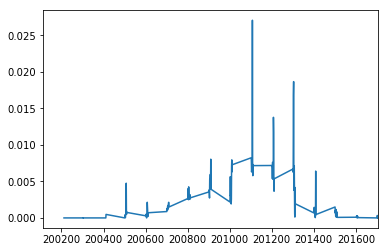

In [18]:
combi_ns0_dict['de']['prop_bot2bot_rv'].plot(kind='line')

In [19]:
pd.options.display.max_rows = 999


In [20]:
pd.concat([df_rev_dict['en'], df_dict['en']])

NameError: name 'df_dict' is not defined